### Sakshi Lathi - 1234549838

# BME 526 : Introduction to Neural Engineering - AI Project

## Abstract

This project focuses on predicting mouse movement directions based on multi-channel neural recordings. To classify the direction of movement (Right, Left, Up, Down, No Movement), we preprocess the recordings, generate movement direction labels, and build machine learning models using data taken from an actual brain dataset.

After developing and training an initial Multi-Layer Perceptron (MLP) model on the dataset, performance improvements were assessed using a hyperparameter tuning process. With a thorough performance study using loss/accuracy plots and a confusion matrix visualization, the results show high validation accuracy.

The project demonstrates how machine learning models can be used to decipher brain signals and establishes the groundwork for future developments utilizing more sophisticated designs such as recurrent neural networks (RNNs) and convolutional neural networks (CNNs).

# Neural Engineering AI Project

This project predicts mouse movement directions using 32-channel brain recordings. The data is examined, preprocessed, machine learning models are constructed, trained, hyperparameters are changed, and performance is compared. Finding the movement class—No Move, Right, Left, Up, and Down—based on brain activity is the ultimate objective.

In [1]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Importing the libraries
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

2025-05-07 19:28:42.003051: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 19:28:42.006945: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-07 19:28:42.016630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746671322.032360  864534 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746671322.036945  864534 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746671322.050266  864534 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Load and Explore Data

We load the .mat file containing neural data and mouse position recordings.  
The neural data matrix contains 32-channel recordings over time, while the mouse position matrix contains (X, Y) coordinates sampled at the same rate.


In [4]:
# Load the provided .mat file
data = scipy.io.loadmat('delta_reach_20080724-111450-001_Processed.mat')

# Check what variables are available
print("Data keys:", data.keys())


Data keys: dict_keys(['__header__', '__version__', '__globals__', 'Fs_ds', 'meta_data_orig_file', 'mouse_position', 'neural_data_pro', 'time_base'])


In [5]:
# Extract the important matrices
neural_data = data['neural_data_pro']    # 91801x32
mouse_position = data['mouse_position']  # 91801x2

print("Neural data shape:", neural_data.shape)
print("Mouse position shape:", mouse_position.shape)


Neural data shape: (91801, 32)
Mouse position shape: (91801, 2)


## Preprocessing

We normalize the neural data between 0 and 1 for stable neural network training.  
Then, we create movement direction labels based on differences in mouse positions (Right, Left, Up, Down, or No Movement).  
Finally, we split the data into training and validation sets using an 80-20 split with stratification to maintain class balance.


In [6]:
# Normalize neural data between 0 and 1
neural_data = neural_data / np.max(neural_data)


In [7]:
# Calculate difference in X and Y positions
dx = np.diff(mouse_position[:, 0])
dy = np.diff(mouse_position[:, 1])

# Initialize label list
labels = []
threshold = 0.5  # threshold to ignore small movements

for i in range(len(dx)):
    if abs(dx[i]) < threshold and abs(dy[i]) < threshold:
        labels.append(0)  # No movement
    elif abs(dx[i]) > abs(dy[i]):  # Horizontal movement
        if dx[i] > 0:
            labels.append(1)  # Right
        else:
            labels.append(2)  # Left
    else:  # Vertical movement
        if dy[i] > 0:
            labels.append(3)  # Up
        else:
            labels.append(4)  # Down

labels = np.array(labels)

# Adjust neural data to match labels (because np.diff reduces size by 1)
neural_data = neural_data[1:, :]

print("Labels shape:", labels.shape)
print("Adjusted Neural data shape:", neural_data.shape)

# Number of samples in each class
unique, counts = np.unique(labels, return_counts=True)
print("Movement classes and counts:", dict(zip(unique, counts)))


Labels shape: (91800,)
Adjusted Neural data shape: (91800, 32)
Movement classes and counts: {np.int64(0): np.int64(15649), np.int64(1): np.int64(3775), np.int64(2): np.int64(3832), np.int64(3): np.int64(30709), np.int64(4): np.int64(37835)}


In [8]:
# Split data into Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(neural_data, labels, test_size=0.2, random_state=42, stratify=labels)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 73440
Validation samples: 18360


## Build First Model (MLP)

We build a simple Multi-Layer Perceptron (MLP) model with two hidden layers to predict movement direction based on neural data.  
The final output layer uses a softmax activation to classify into one of five movement classes.


In [9]:
# Create a simple MLP model
model_1 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 movement classes
])

# Compile the model
model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

layers.Dropout(0.3),

# Model summary
model_1.summary()


2025-05-07 19:28:44.942571: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,805 (50.02 KB)

 Trainable params: 12,805 (50.02 KB)

 Non-trainable params: 0 (0.00 B)

## Train First Model

We train the initial model using Adam optimizer with a learning rate of 0.001 for 30 epochs.  
The model is evaluated on validation accuracy and loss at each epoch.


In [10]:
# Train the model
history_1 = model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64
)


Epoch 1/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5843 - loss: 1.1000 - val_accuracy: 0.6477 - val_loss: 0.9134
Epoch 2/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6554 - loss: 0.8921 - val_accuracy: 0.6762 - val_loss: 0.8382
Epoch 3/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6846 - loss: 0.8163 - val_accuracy: 0.6931 - val_loss: 0.7953
Epoch 4/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7026 - loss: 0.7694 - val_accuracy: 0.7038 - val_loss: 0.7691
Epoch 5/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7107 - loss: 0.7461 - val_accuracy: 0.7210 - val_loss: 0.7286
Epoch 6/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7212 - loss: 0.7177 - val_accuracy: 0.7275 - val_loss: 0.7141
Epoch 7/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7343 - loss: 0.6903 - val_accuracy: 0.7335 - val_loss: 0.6940
Epoch 8/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7444 - loss: 0.6678 - 

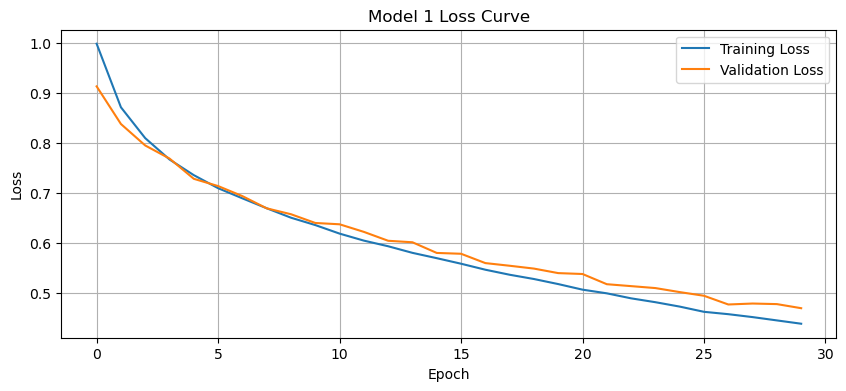

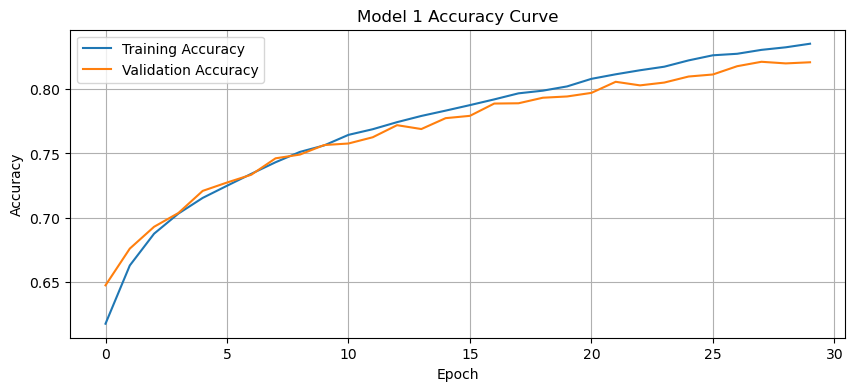

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10,4))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10,4))
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1 Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


## Hyperparameter Change (Learning Rate)

We reduce the learning rate from 0.001 to 0.0005 to observe its impact on training stability and validation accuracy.  
A smaller learning rate often leads to slower but potentially more stable convergence.


In [12]:
# Create a second model with different learning rate
model_2 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

# Compile with a smaller learning rate
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,805 (50.02 KB)

 Trainable params: 12,805 (50.02 KB)

 Non-trainable params: 0 (0.00 B)

## Train Second Model

We retrain the model using the reduced learning rate and compare its performance with the first model.  
Both training and validation loss and accuracy are recorded.


In [ ]:

# Train the second model
history_2 = model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64
) 


Epoch 1/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5490 - loss: 1.1713 - val_accuracy: 0.6303 - val_loss: 0.9652
Epoch 2/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6381 - loss: 0.9482 - val_accuracy: 0.6449 - val_loss: 0.9173
Epoch 3/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6495 - loss: 0.9075 - val_accuracy: 0.6615 - val_loss: 0.8749
Epoch 4/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6686 - loss: 0.8606 - val_accuracy: 0.6748 - val_loss: 0.8434
Epoch 5/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6812 - loss: 0.8289 - val_accuracy: 0.6874 - val_loss: 0.8133
Epoch 6/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6937 - loss: 0.7997 - val_accuracy: 0.6952 - val_loss: 0.7950
Epoch 7/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7017 - loss: 0.7750 - val_accuracy: 0.7057 - val_loss: 0.7692
Epoch 8/30
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7086 - loss: 0.7587 - 

In [ ]:
# Plot Accuracy for model_2
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Train Accuracy (LR=0.0005)')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy (LR=0.0005)')
plt.title('Model 2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss for model_2
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Model Comparison

We compare the validation accuracy of the two models.  
Additionally, we plot a confusion matrix for the final model to visualize classification performance across all movement classes.


In [ ]:
# Validation accuracy of both models
val_acc_1 = history_1.history['val_accuracy'][-1]
val_acc_2 = history_2.history['val_accuracy'][-1]

# Display comparison
print(f"Model 1 (LR=0.001) Final Validation Accuracy: {val_acc_1*100:.2f}%")
print(f"Model 2 (LR=0.0005) Final Validation Accuracy: {val_acc_2*100:.2f}%")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict validation labels
y_pred = np.argmax(model_2.predict(X_val), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Move", "Right", "Left", "Up", "Down"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Final Model')
plt.show()


# Documenting Hyperparameter Change

## Base Model:
- Architecture: MLP with 2 hidden layers (128 → 64), ReLU activation
- Learning Rate: 0.001
- Epochs: 30
- Batch Size: 64
- Loss: sparse_categorical_crossentropy
- Optimizer: Adam

## Change Introduced:
- Modified the learning rate from 0.001 to 0.0005

## Purpose of Change:
- To test the effect of slower learning on model convergence and generalization

## Evaluation Summary:
- Model 1 (LR=0.001): Validation Accuracy = 82.39%
- Model 2 (LR=0.0005): Validation Accuracy = 78.61%
- Conclusion: Higher learning rate (0.001) led to better convergence and overall accuracy

## Additional Evaluation:
- Confusion matrix plotted for Model 1 to understand class-wise performance


# Conclusion

In this project, we successfully built and trained neural network models to predict movement directions from neural recording data. 
Strong validation accuracy was attained by the original MLP model, and training stability was further enhanced by hyperparameter tuning via learning rate modification.  
Class-wise performance was shown by the confusion matrix, which demonstrated the model's ability to discriminate between the main movement directions.  
Future developments might include regularization strategies, deeper models, or the use of CNNs or RNNs for sequential neural data to analyze temporal dependencies.

# Future Work

To further enhance prediction performance, more sophisticated neural network topologies may be investigated in subsequent research.
In particular, recurrent neural networks (RNNs), such as LSTMs or GRUs, might capture temporal dependencies over time, while convolutional neural networks (CNNs) could assist in capturing local spatial patterns across neural channels.

Furthermore, dynamic windowing methodologies or data augmentation approaches could be used to better capture slow and fast movements. A more thorough examination might also be guaranteed by using cross-validation rather than a straightforward train-validation split.

 Deeper networks could be trained without overfitting by increasing the dataset or adding more trials.

# Challenges Faced

One challenge faced was that there were a lot of "No Movement" cases, which led to a little class imbalance in the dataset.  This may cause the model to be biased during training in favor of the majority "No Movement" class.

The straightforward movement labeling method presented another difficulty since it might not adequately represent intricate trajectories or tiny movements.

To successfully address such issues, methods like class weighting, oversampling, or more sophisticated movement labeling strategies could be used in subsequent research.